# Autoencoder

Autor: Rafał Masełek

Sieci typu Autoencoder (AE), po polsku pewnie byłby "autokoder", to jedna z bardziej interesujących a przy tym stosunkowo prostych architektur. Sieci takie charakteryzują się tym, że ich dane wejściowe i wyjściowe mają identyczne rozmiary, co pozwala na poddawanie oryginalnych danych obróbce i bezpośrednim porównywaniu z oryginałem, bez potrzeby używania etykiet klas. Zatem autokodery powalają na uczenie bez nadzoru. Zazwyczaj interesują nas autokodery, które dokonują kompresji danych, takie sieci graficznie można przedstawić jako stopniowo zwężające się w środku a nastepnie rozszerzające się do oryginalnych rozmiarów.

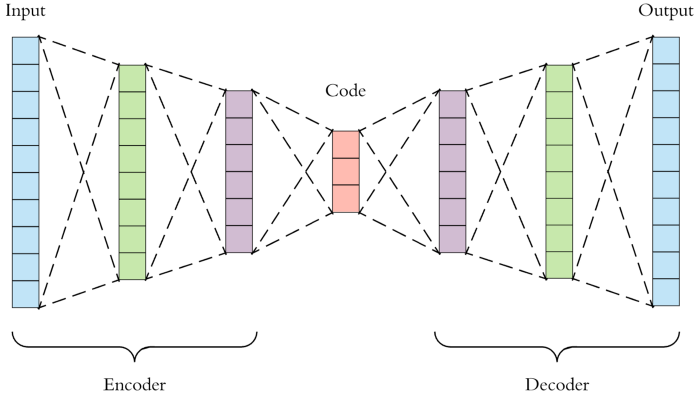

Autokoder składa się z dwóch części: kodera i dekodera. Pierwszy modyfikuje oryginalne dane, zazwyczaj je kompresując, naomiast koder dekoduje dane do oryginalnej postaci. Nie specyfikujemy a priori sposobu kodowania, sieć neuronowa sama uczy się optymalnego sposobu, stąd nazwa "autoencoder". Najpopularniejszą metodą uczenia autokoderów jest użycie błędu średniokwadratowego:

$\mathrm{MSE} = \frac{1}{n}\sum_{\mathrm{i}}^n \left(x_i - \tilde{x_i}\right)^2$

Gdzie $x_i$ to dane wejściowe (np. wartości pikseli obrazka), $\tilde x_i$ dane wyjściowe, a takich danych jest n w próbce.

#### Autokodery mają kilka interesujących zastosowań:
1. Pozwalają na kompresję danych, jeżeli ich środkowa część, którą będę nazywał przestrzenią ukrytą, ma mniejszą wymiarowość niż warstwy wejściowa/wyjściowa. 
2. Można ich użyć do odszumiania danych.
3. Można ich użyć do szukania anomalii, czyli rodzajów danych nieobecnych podczas procesu uczenia.
4. Po pewnych modyfikacjach mozna je użyć do generowania nowych danych, np. twarzy.

W dzisiejszym notatniku zajmiemy się odszumianiem danych.

## Wczytanie i wstępna obróbka danych

In [79]:
import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow.keras import *
from tensorflow import random
from tensorflow.keras.datasets import fashion_mnist
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### Ładujemy obrazki ubrań z Zalando (FASHION MNIST)

Zbiór obrazków ubrań jest dostępny bezpośrednio poprzez Kerasa i wczytuje się go identycznie jak zbiór ręcznie pisanych cyfr.

In [80]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print("Training data features:", X_train.shape)
print("Training data labels:", y_train.shape)

print("Test data features:", X_test.shape)
print("Test data labels:", y_test.shape)

Training data features: (60000, 28, 28)
Training data labels: (60000,)
Test data features: (10000, 28, 28)
Test data labels: (10000,)


Jeżeli powyżej dostałeś błąd ssl to spróbuj odkomentować i odpalić najpierw poniższa komórkę.

In [81]:
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     # Legacy Python that doesn't verify HTTPS certificates by default
#     pass
# else:
#     # Handle target environment that doesn't support HTTPS verification
#     ssl._create_default_https_context = _create_unverified_https_context


Normalizujemy dane tak, żeby wartości pikseli były w przedziale [0,1]

In [82]:
maxval = np.amax(X_train)
X_train = X_train/maxval
X_test =  X_test/maxval

Specyfikujemy jawnie liczbę kanałów

In [83]:
def add_chan(Z):
    if len(Z.shape) == 3:
        return Z.reshape(Z.shape[0], Z.shape[1], Z.shape[2], 1)
    else:
        return Z

X_train = add_chan(X_train)
X_test = add_chan(X_test)

In [84]:
print("Training data features:", X_train.shape)
print("Test data features:", X_test.shape)

Training data features: (60000, 28, 28, 1)
Test data features: (10000, 28, 28, 1)


Wyświetlimy kilka pierwszych zdjęć wraz z etykietą klas.

In [85]:
# definiujemy funkcję do wyświetlania obrazków, przyda się później
def plot(dataX, dataY):
    n = 4
    fig, axs = plt.subplots(n,n, figsize=(10,10)) 
    for ii in range(n*n):
        axs[ii//n, ii%n].imshow(dataX[ii], cmap='gray')
        axs[ii//n, ii%n].title.set_text('Klasa: {}'.format(dataY[ii]))
        plt.tight_layout()
    plt.show()

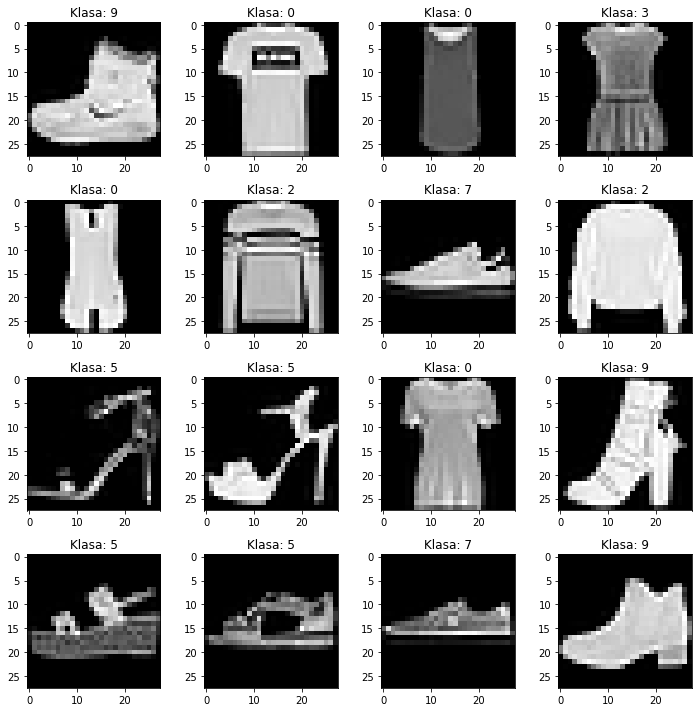

In [86]:
plot(X_train, y_train)

## Budujemy sieć

Poprzez zmienną będziemy regulować romiar (wymiar) przetrzeni ukrytej (ang. latent space)

In [87]:
latent_dim = 2

Poniższa klas definiuje model typu autoencoder. Robi to tworząc koder i dekoder w moemencie uruchomienia, a w momencie wywołania najpierw koduje, a później dekoduje dane. 

#### Uzupełnij fragmenty kodu i zdefiniuj w nich koder, który składa się z następujących warstw:
1. Warstwa wejściowa na obrazki
2. Warstwa konwolucyjna, 64 filtry 3x3, padding="same"
3. MaxPooling, 2x2, , strides=2, padding="valid"
4. Warstwa konwolucyjna, 64 filtry 3x3, padding="same"
5. MaxPooling, 2x2, , strides=2, padding="valid"
6. Warstwa spłaszczająca
7. Warstwa gęsta, 64 neurony
8. Warstwa gęsta, tyle neuronów co w latent_dim

Taka architektura sprawi, że przestrzenne wymiary obrazka będą maleć 2 razy po każdym poolingu.

#### Uzupełnij fragmenty kodu i zdefiniuj w nich dekoder, który składa się z następujących warstw:
1. Warstwa wejściowa odpowiadająca rozmiarowi przestrzeni ukrytej
2. Warstwa gęsta, 49 neuronów
3. Warstwa typu Reshape, nadaj danym wymiar 7x7x1
4. Warstwa konwolucyjna transponowana, 64 filtry 3x3, padding="same", strides=2
5. Warstwa konwolucyjna transponowana, 64 filtry 3x3, padding="same", strides=2
6. Warstwa konwolucyjna, 1 filtr 3x3, padding="same", funkcja aktywacyjna sigmoida

Najpierw nadajemy danym odpowiedni wymiar przestrzenny, później za pomocą wartsw konwolucyjnych transponowanych dwa razy zwiększamy wymiary dwukrotnie, czyli (7,7) -> (14,14) -> (28,28). Ostatnia warstwa konwolucyjna przywróci nam jeden kanał.

In [88]:
# w tej klasie implementujemy nasz model
class Autoencoder(Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    
    # create encoder
    ################### MIEJSCE NA TWOJ KOD
    NN = ... 
    # set up field
    self.encoder = NN
    
    # create decoder
    ################### MIEJSCE NA TWOJ KOD
    NN = ...
     # set up field
    self.decoder = NN

  def call(self, x):
    # use fields to create autoencoder
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded



## Odszumianie zdjęć (denoising)

Dodamy teraz losowy szum do zdjęć i spróbujemy go usunąć za pomocą autoencodera.

In [89]:
# zaszumimy nasze obrazki szumem Gaussowskim
noise_factor = 0.15
X_train_noisy = X_train + noise_factor * random.normal(shape=X_train.shape) 
X_test_noisy = X_test + noise_factor * random.normal(shape=X_test.shape) 

Wyświetlimy te same zdjęcia co poprzednio

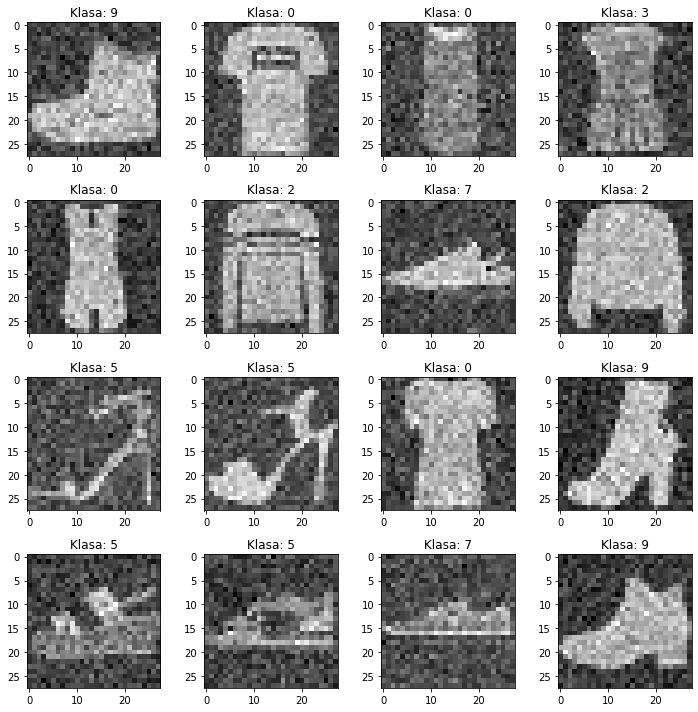

In [90]:
plot(X_train_noisy, y_train)

### Uczymy sieć bez nadzoru

In [91]:
# tworzymy i kompilujemy nasz model
autoencoder = Autoencoder()
opt = optimizers.Adam(learning_rate=1e-3)
autoencoder.compile(optimizer=opt, loss=losses.MeanSquaredError())

Nauczymy sieć używając tylko obrazków, bez etykiet. Do walidacji użyjemy dla ułatwienia zbioru testowego.

In [92]:
# uczymy sieć
h = autoencoder.fit(X_train_noisy, X_train,
                epochs=10,
                batch_size=64,
                validation_split=0.3)

Epoch 1/10
657/657 [==============================] - 176s 267ms/step - loss: 0.0571 - val_loss: 0.0441
Epoch 2/10
657/657 [==============================] - 179s 273ms/step - loss: 0.0433 - val_loss: 0.0414
Epoch 3/10
657/657 [==============================] - 186s 284ms/step - loss: 0.0413 - val_loss: 0.0399
Epoch 4/10
657/657 [==============================] - 170s 259ms/step - loss: 0.0400 - val_loss: 0.0413
Epoch 5/10
657/657 [==============================] - 193s 293ms/step - loss: 0.0393 - val_loss: 0.0405
Epoch 6/10
657/657 [==============================] - 161s 246ms/step - loss: 0.0387 - val_loss: 0.0378
Epoch 7/10
657/657 [==============================] - 184s 280ms/step - loss: 0.0383 - val_loss: 0.0396
Epoch 8/10
657/657 [==============================] - 160s 244ms/step - loss: 0.0378 - val_loss: 0.0371
Epoch 9/10
657/657 [==============================] - 194s 295ms/step - loss: 0.0375 - val_loss: 0.0368
Epoch 10/10
657/657 [==============================] - 173s 264m

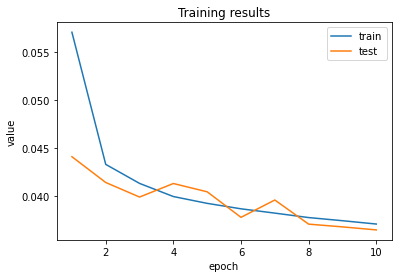

In [93]:
# wypisujemy postępy uczenia sieci
epochs = list( range(1, len(h.history['loss'])+1 ) )
plt.plot(epochs, h.history['loss'], label='train')
plt.plot(epochs, h.history['val_loss'], label='test')
plt.xlabel('epoch')
plt.ylabel('value')
plt.legend()
plt.title('Training results')
plt.show()

### sprawdźmy działanie sieci na zbiorze testowym

In [94]:
# najpierw zakodujemy obrazki ze zbioru testowego
encoded_imgs = autoencoder.encoder(X_test).numpy()
# a później odkodujemy
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

Wyświetlimy dla porównania obrazki przed i po odszumianiu

In [95]:
from tensorflow import squeeze

def compare(data_pre, data_post):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):

        # display original + noise
        ax = plt.subplot(2, n, i + 1)
        plt.title("original")
        plt.imshow(squeeze(data_pre[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        bx = plt.subplot(2, n, i + n + 1)
        plt.title("reconstructed")
        plt.imshow(squeeze(data_post[i]))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
    plt.show()

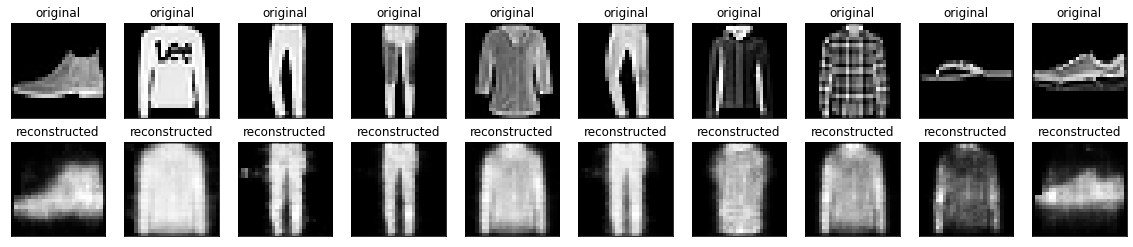

In [96]:
compare(X_test, decoded_imgs)

#### Co możesz powiedzieć o działaniu autodekodera? Jak można by poprawić wyniki?

Zobaczmy jak sieć radzi sobie z poszczególnymi klasami, narysujmy histogram MSE w zależności od klasy:

Text(0.5, 0, 'MSE')

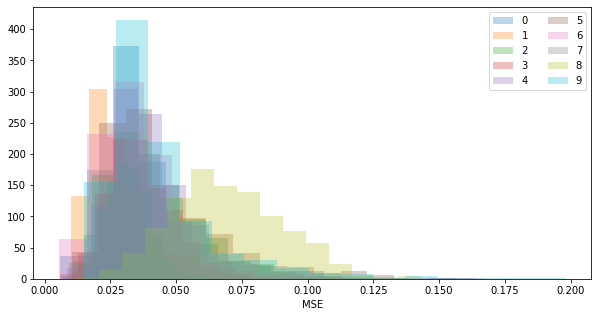

In [97]:
plt.figure(figsize=(10,5))

for klasa in range(10):
    # dla kazdej klasy wybieramy odpowiednie dane i plotujemy
    ind = np.where(y_test == klasa)
    original = X_test[ind]
    reconstructed = decoded_imgs[ind]
    mse = ((original - reconstructed)**2).sum(axis=2).sum(axis=1)/28./28.
    plt.hist(mse, 15, alpha=0.3, label=f'{klasa}')
    

plt.legend(ncol=2)
plt.xlabel('MSE')

#### Co można powiedzieć o tych wynikach? Dla której klasy odszumianie wychodzi najgorzej? Z czego to może wynikać?

#### Zobaczmy jak wyglądają zakodowane obrazki w dwóch pierwszych wymiarach przestrzeni ukrytej.

In [98]:
encoded_imgs.shape

(10000, 2)

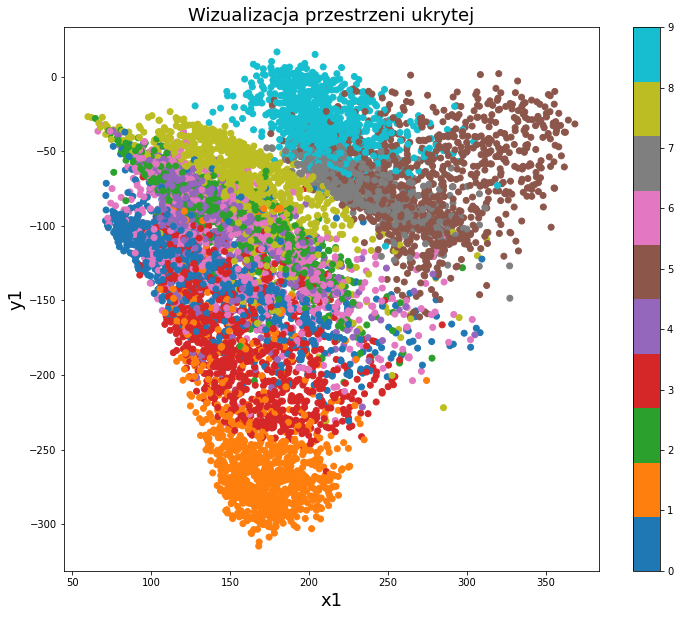

In [99]:
# nasza przestrzeń jest dwuwymiarowa, więc będzie prosto
xx = encoded_imgs[:, 0]
yy = encoded_imgs[:, 1]
zz = y_test

fig = plt.figure(figsize=(12,10))
plt.scatter(xx, yy, c=zz, cmap='tab10')
plt.xlabel('x1', fontsize=18)
plt.ylabel('y1', fontsize=18)
plt.colorbar()
plt.title('Wizualizacja przestrzeni ukrytej', fontsize=18)
plt.show()


## Wykrywanie anomalii

Spróbujemy teraz użyć autokodera do wykrywania anomalii. Naszą anomalią będzie klasa 8 (torby). Wytrenujemy nasz Autokoder na obrazkach z pozostałych klas, a następnie sprawdzimy jego działanie na zbiorze testowym. Spodziewamy się, że sieć nauczy się rekonstruować poprawnie obrazki "normalnych" klas, a znacznie gorzej będzie radzić sobie z nieznanymi obiektami klasy nr 8. Czyli wartość błędu średniokwadratowego powinna być wyższa dla klasy anomalnej. Możemy zatem stworzyć klasyfikator binarny wykorzystujący MSE, który pozwoli nam rozpoznać obrazki niepodobne do niczego co sieć widziała w trakcie uczenia -- wykrywacz anomalii. Opisany sposób uczenia sieci nazywa się uczeniem z częściowym nadzorem (semi-supervised), ponieważ wiemy, że w zbiorze uczącym nie ma anomalii. Uczenie bez nadzoru zakładałoby możliwą niewielką obecność anomalii w zbiorze uczącym.

In [100]:
anomaly=8

Przejdźmy do pracy. Usuń z danych uczących wszystkie obrazki z klasy 8 i wytrenuj nasz model (uwaga: proszę stworzyć nową instancję obiektu, nie używać już trenowanej sieci).

In [101]:
# usuń anomalie z danych uczących
X_train_new = ...

In [102]:
# stwórz model
autoencoder = Autoencoder()
opt = optimizers.Adam(learning_rate=1e-3)
autoencoder.compile(optimizer=opt, loss=losses.MeanSquaredError())

In [103]:
# wytrenuj model używając tym razem tych samych danych na wejściu i wyjściu
h = ...

Epoch 1/10
591/591 [==============================] - 134s 225ms/step - loss: 0.0596 - val_loss: 0.0437
Epoch 2/10
591/591 [==============================] - 130s 220ms/step - loss: 0.0404 - val_loss: 0.0385
Epoch 3/10
591/591 [==============================] - 127s 216ms/step - loss: 0.0384 - val_loss: 0.0401
Epoch 4/10
591/591 [==============================] - 130s 220ms/step - loss: 0.0374 - val_loss: 0.0371
Epoch 5/10
591/591 [==============================] - 133s 224ms/step - loss: 0.0366 - val_loss: 0.0361
Epoch 6/10
591/591 [==============================] - 143s 242ms/step - loss: 0.0359 - val_loss: 0.0353
Epoch 7/10
591/591 [==============================] - 151s 255ms/step - loss: 0.0354 - val_loss: 0.0351
Epoch 8/10
591/591 [==============================] - 142s 240ms/step - loss: 0.0352 - val_loss: 0.0349
Epoch 9/10
591/591 [==============================] - 188s 318ms/step - loss: 0.0347 - val_loss: 0.0343
Epoch 10/10
591/591 [==============================] - 186s 315m

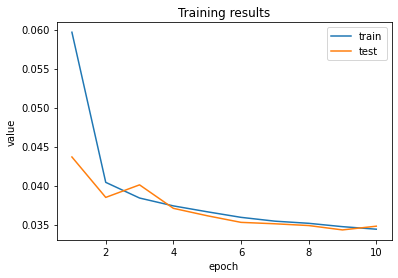

In [104]:
# narysuj postępy uczenia sieci
epochs = list( range(1, len(h.history['loss'])+1 ) )
plt.plot(epochs, h.history['loss'], label='train')
plt.plot(epochs, h.history['val_loss'], label='test')
plt.xlabel('epoch')
plt.ylabel('value')
plt.legend()
plt.title('Training results')
plt.show()

Użyj autokodera do zakodowania i odkodowania obrazków ze zbioru testowego.

In [105]:
encoded_imgs = autoencoder.encoder(X_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

Porównamy kilka obrazków ze zbioru testowego i rekonstrukcji, żeby sprawdzić, czy nasz autokoder w ogóle działa.

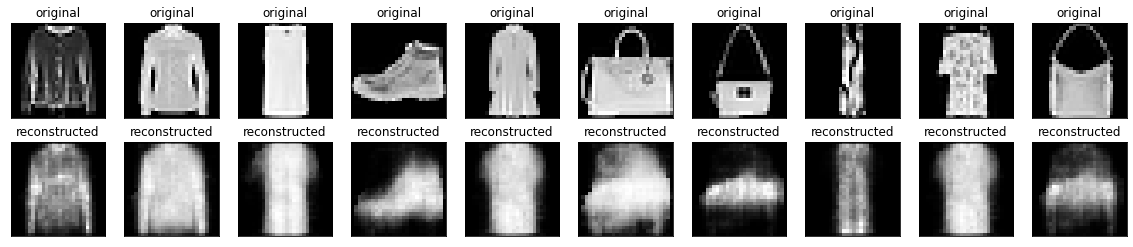

In [106]:
compare(X_test[25:], decoded_imgs[25:])
# wyświetlam od 25, żeby mieć obrazek klasy 8

#### Dlaczego obrazek torby został zrekonstruowany gorzej niż inne?

### Ewaluacja

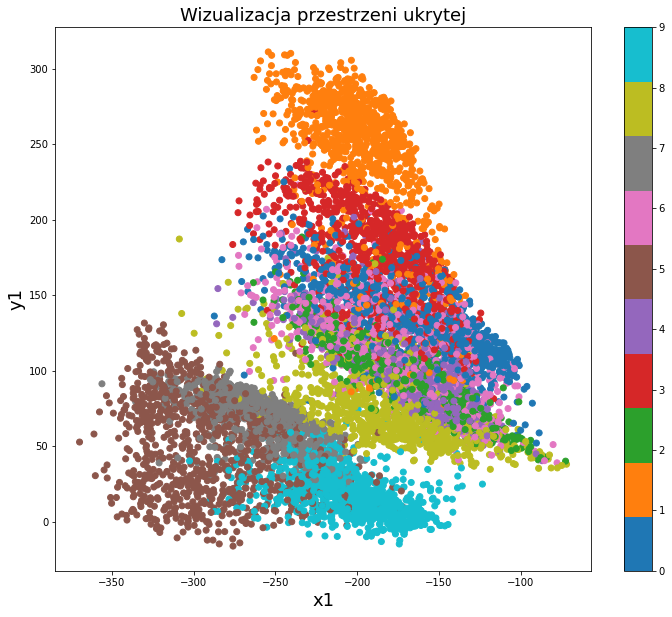

In [107]:
# Narysuj rozkład klas w przestrzeni ukrytej. Zwróć szczególną uwagę na anomalną klasę.

xx = encoded_imgs[:, 0]
yy = encoded_imgs[:, 1]
zz = y_test

fig = plt.figure(figsize=(12,10))
plt.scatter(xx, yy, c=zz, cmap='tab10')
plt.xlabel('x1', fontsize=18)
plt.ylabel('y1', fontsize=18)
plt.colorbar()
plt.title('Wizualizacja przestrzeni ukrytej', fontsize=18)
plt.show()


Text(0.5, 0, 'MSE')

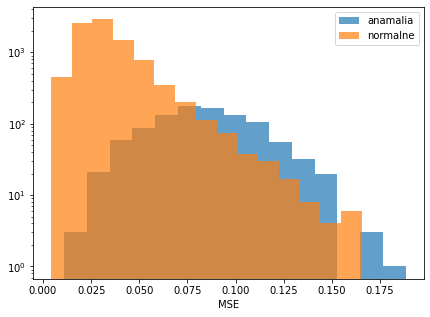

In [108]:
# narysuj histogram MSE dla klasy anomalnej i pozostałych (łącznie)
plt.figure(figsize=(7,5))
################### MIEJSCE NA TWOJ KOD
...

plt.yscale('log')
plt.legend()
plt.xlabel('MSE')

Możemy uzyć tych danych do klasyfikacji binarnej, przyjmiemy, że powyżej pewnej wartości MSE wszystkie obrazki przedstawiają anomalię, natomiast te z mniejszym MSE normalne dane.

In [109]:
from sklearn.metrics import precision_recall_curve, roc_curve

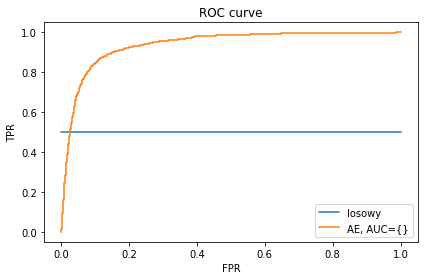

In [110]:
# Rysowanie krzywej ROC
MSE = ...
FPR, TPR, THR = ...
plt.plot([0,1],[0.5,0.5], label='losowy')
plt.plot(FPR, TPR, label='AE')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend()
plt.tight_layout()
plt.show()

(10000, 1)


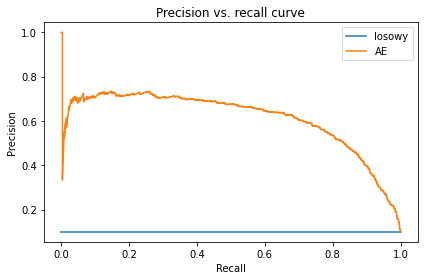

In [112]:
# Rysowanie krzywej Precision vs Recall
PPV, REC, THR = ...
plt.plot([0,1],[0.1,0.1], label='losowy')
plt.plot(REC, PPV, label='AE')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision vs. recall curve')
plt.legend()
plt.tight_layout()
plt.show()

#### Która z dwóch krzywych lepiej oddaje skuteczność naszego klasyfikatora i dlaczego? Jak możnaby poprawić jego działanie?